In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nvidia-stock-data/NVIDIA_STOCK.csv


In [129]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

In [46]:
df = pd.read_csv("/kaggle/input/nvidia-stock-data/NVIDIA_STOCK.csv")

In [47]:
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB
None


In [49]:
df.isnull()

,Price,Adj Close,Close,High,Low,Open,Volume
0,False,False,False,False,False,False,False
1,False,True,True,True,True,True,True
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1694,False,False,False,False,False,False,False
1695,False,False,False,False,False,False,False
1696,False,False,False,False,False,False,False
1697,False,False,False,False,False,False,False


In [50]:
df.dropna()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000
5,2018-01-05,5.326793670654297,5.385000228881836,5.422749996185303,5.2769999504089355,5.354750156402588,580124000
...,...,...,...,...,...,...,...
1694,2024-09-24,120.8616714477539,120.87000274658203,121.80000305175781,115.37999725341797,116.5199966430664,354966800
1695,2024-09-25,123.50149536132812,123.51000213623047,124.94000244140625,121.61000061035156,122.0199966430664,284692900
1696,2024-09-26,124.03145599365234,124.04000091552734,127.66999816894531,121.80000305175781,126.80000305175781,302582900
1697,2024-09-27,121.39163970947266,121.4000015258789,124.02999877929688,119.26000213623047,123.97000122070312,271009200


In [51]:
df = df.iloc[2:]  
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [52]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000
5,2018-01-05,5.326793670654297,5.385000228881836,5.422749996185303,5.2769999504089355,5.354750156402588,580124000
6,2018-01-08,5.490012168884277,5.550000190734863,5.625,5.4644999504089355,5.510000228881836,881216000
...,...,...,...,...,...,...,...
1694,2024-09-24,120.8616714477539,120.87000274658203,121.80000305175781,115.37999725341797,116.5199966430664,354966800
1695,2024-09-25,123.50149536132812,123.51000213623047,124.94000244140625,121.61000061035156,122.0199966430664,284692900
1696,2024-09-26,124.03145599365234,124.04000091552734,127.66999816894531,121.80000305175781,126.80000305175781,302582900
1697,2024-09-27,121.39163970947266,121.4000015258789,124.02999877929688,119.26000213623047,123.97000122070312,271009200


In [53]:
df['Date'] = pd.to_datetime(df['Date'])

In [54]:
numeric_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [55]:
df = df.reset_index(drop=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000


In [56]:
print(df.describe())

                                Date    Adj Close        Close         High  \
count                           1697  1697.000000  1697.000000  1697.000000   
mean   2021-05-16 04:49:21.461402368    24.797593    24.828411    25.295239   
min              2018-01-02 00:00:00     3.151430     3.177000     3.249500   
25%              2019-09-10 00:00:00     6.113620     6.161750     6.250000   
50%              2021-05-17 00:00:00    13.985092    14.015750    14.243500   
75%              2023-01-23 00:00:00    27.088902    27.104000    27.496000   
max              2024-09-30 00:00:00   135.559067   135.580002   140.759995   
std                              NaN    29.221442    29.216014    29.811740   

               Low         Open        Volume  
count  1697.000000  1697.000000  1.697000e+03  
mean     24.315422    24.823341  4.716865e+08  
min       3.111500     3.162250  9.788400e+07  
25%       6.064250     6.166250  3.278440e+08  
50%      13.750000    14.033750  4.349650e+08  


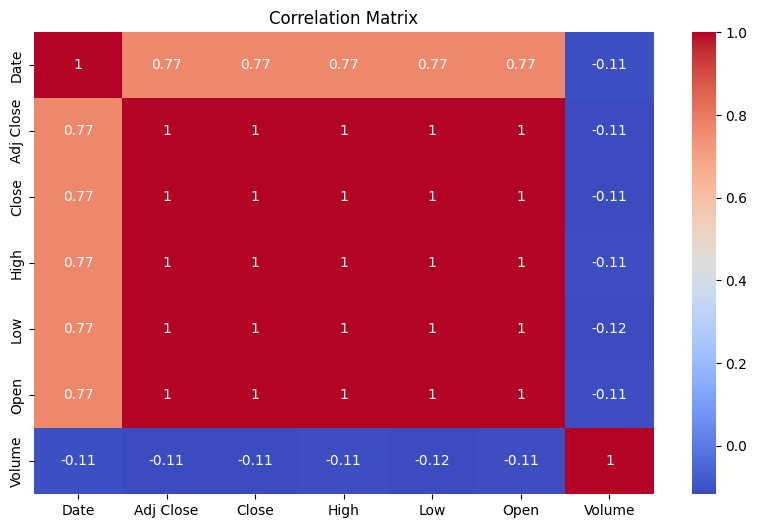

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

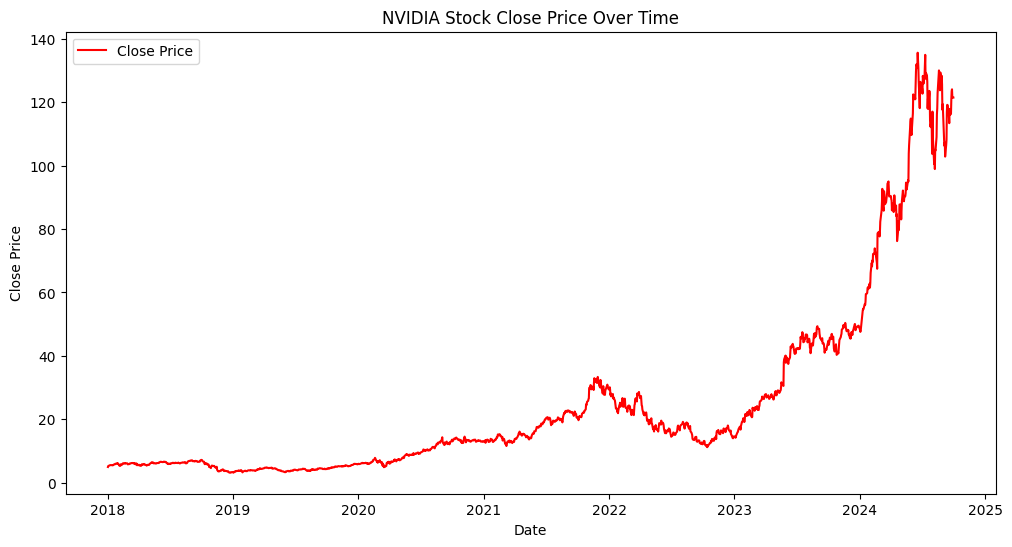

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='red')
plt.title('NVIDIA Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

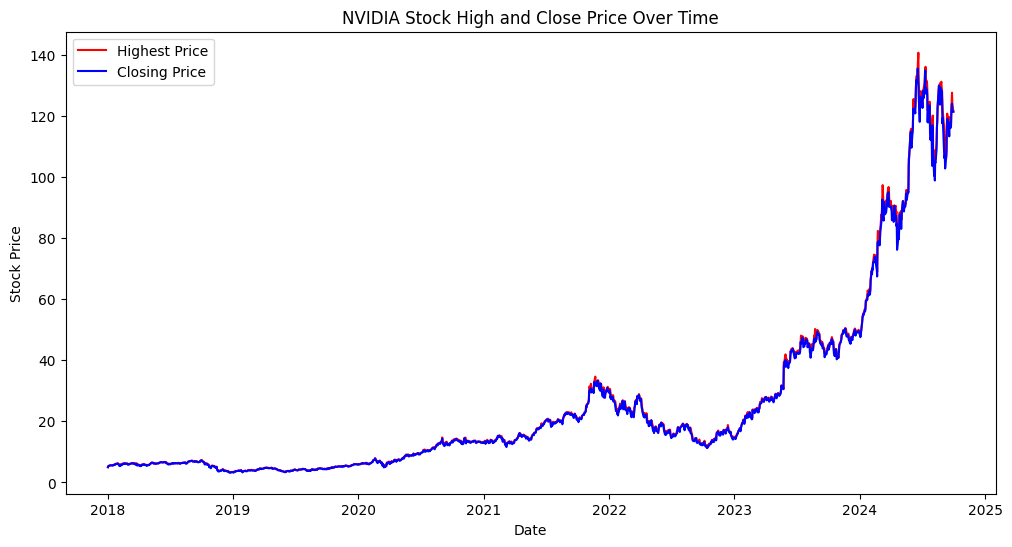

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['High'], label='Highest Price', color='red')
plt.plot(df['Date'], df['Close'], label='Closing Price', color='Blue')
plt.title('NVIDIA Stock High and Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [75]:
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,0.013432,0.013646,0.012639,0.013541,0.012678,0.106781
1,2018-01-03,0.015882,0.016123,0.015221,0.015330,0.014200,0.338418
2,2018-01-04,0.016091,0.016335,0.016012,0.017058,0.016333,0.201100
3,2018-01-05,0.016429,0.016676,0.015804,0.016747,0.016046,0.199797
4,2018-01-08,0.017662,0.017923,0.017275,0.018197,0.017182,0.324543


In [78]:
df = df.sort_values('Date')
close_prices = df['Close'].values

In [79]:
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

In [80]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]

In [106]:
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i - window_size:i, 0]) 
        y.append(data[i, 0])  
    return np.array(x), np.array(y)

window_size = 60
x_train, y_train = create_sequences(train_data, window_size)

In [107]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) 
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [108]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0023
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.8634e-04
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.6428e-04
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.3559e-04
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.6090e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.3490e-04
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.2459e-04
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 9.8942e-05
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.2186e-04
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.0649e-04


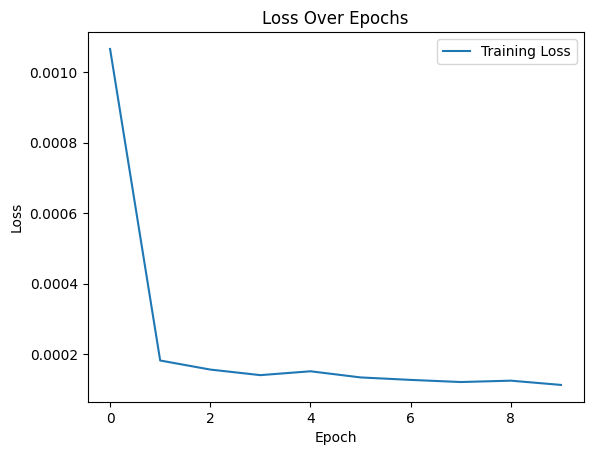

In [109]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
test_data = scaled_data[train_size - window_size:]  # Include overlap
x_test, y_test = create_sequences(test_data, window_size)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [111]:
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

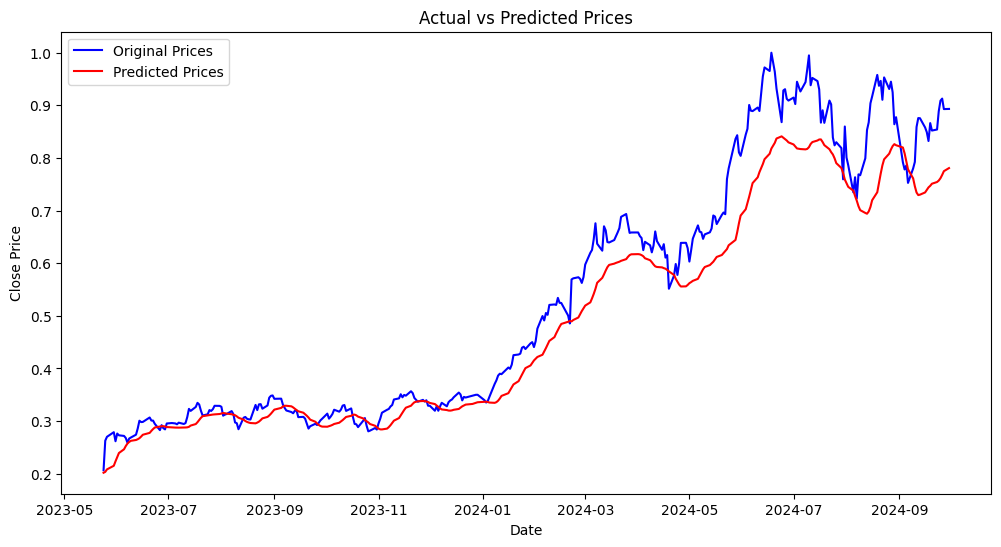

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][train_size:], y_test, color='blue', label='Original Prices')
plt.plot(df['Date'][train_size:], predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [114]:
mae = mean_absolute_error(y_test, predicted_prices)
mse = mean_squared_error(y_test, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.050679813788392314
Mean Squared Error (MSE): 0.0048734389738580115
Root Mean Squared Error (RMSE): 0.06981002058342349
R² Score: 0.9144843746070906


In [117]:
model.save('/kaggle/working/lstm_NVIDIAstock_model.h5')

In [119]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)

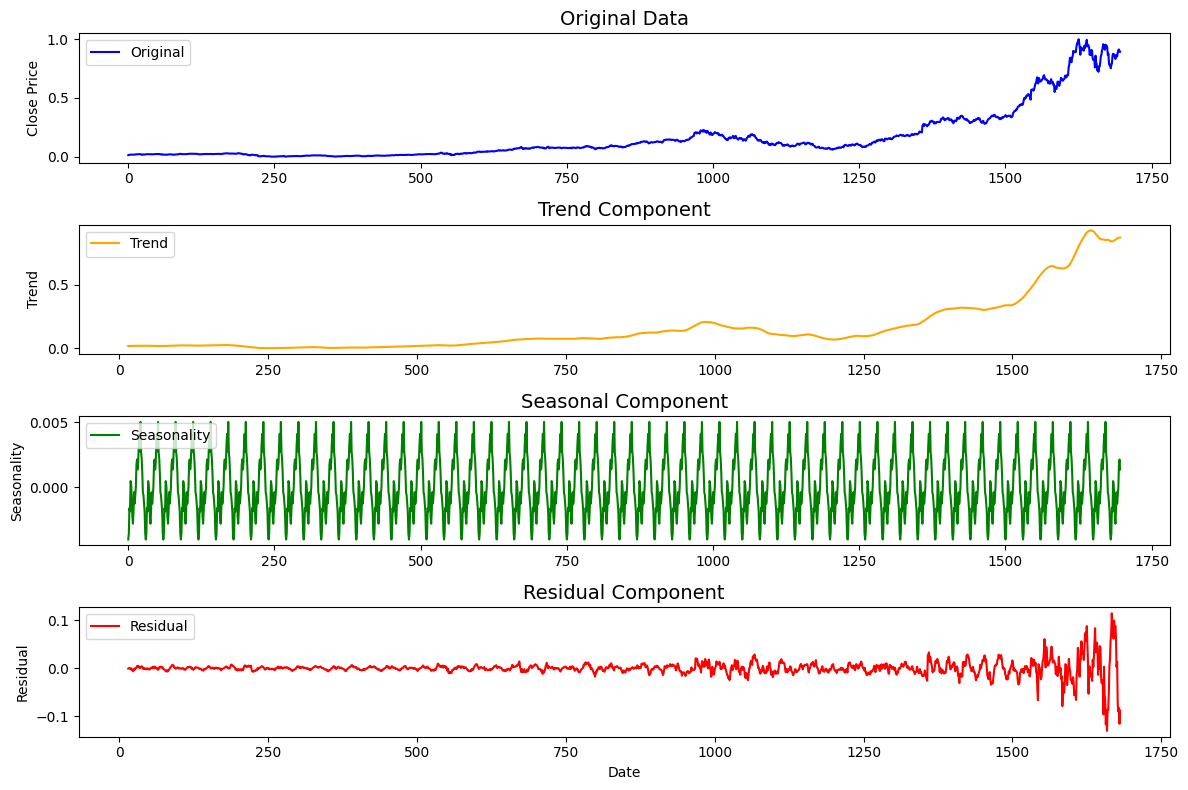

In [124]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Close'], label='Original', color='blue')
plt.title('Original Data', fontsize=14)
plt.ylabel('Close Price')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend Component', fontsize=14)
plt.ylabel('Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component', fontsize=14)
plt.ylabel('Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual Component', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


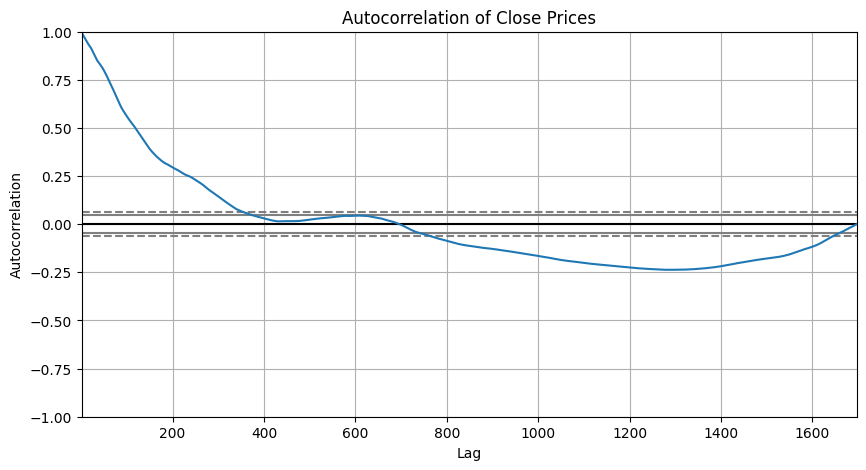

In [127]:
plt.figure(figsize=(10, 5))
autocorrelation_plot(df['Close'])
plt.title('Autocorrelation of Close Prices')
plt.show()

From this figure we find as lag increases autocorrelation decreases until 1300 after which it gradually increases
